<a href="https://colab.research.google.com/github/Murphy-Mary/MyProject/blob/main/game_recommendations_on_steam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import data


souce : https://www.kaggle.com/datasets/antonkozyriev/game-recommendations-on-steam

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

!kaggle datasets download -d antonkozyriev/game-recommendations-on-steam
!unzip /content/game-recommendations-on-steam.zip && rm /content/game-recommendations-on-steam.zip

Mounted at /content/gdrive
100% 112M/112M [00:00<00:00, 160MB/s] 
100% 112M/112M [00:00<00:00, 127MB/s]
Archive:  /content/game-recommendations-on-steam.zip
  inflating: games.csv               
  inflating: games_metadata.json     
  inflating: recommendations.csv     
  inflating: users.csv               


In [2]:
!apt-get update

Get:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Get:2 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Hit:3 http://archive.ubuntu.com/ubuntu focal InRelease
Hit:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu2004/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu2004/x86_64  Release
Get:8 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:10 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Get:11 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Hit:13 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu 

In [3]:
#Get Install the Java Development Kit
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#Get Spark lib -- address need to be change according to the current version of Spark: https://downloads.apache.org/spark/
!wget  http://apache.osuosl.org/spark/spark-3.3.2/spark-3.3.2-bin-hadoop3.tgz
#Unzip th Spark
!tar xf spark-3.3.2-bin-hadoop3.tgz
!rm spark-3.3.2-bin-hadoop3.tgz
#install findspark for Python
!pip install -q findspark
#Install extra lib(s)
!pip install -q xlrd
!pip install -q kaggle
!pip install -q kora

#import and set environment for spark
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.2-bin-hadoop3"
import kora

import findspark
findspark.init()
from pyspark import SparkContext
from pyspark.sql import SparkSession


SPARK_URL = "local[*]"

spark = SparkSession.builder.master(SPARK_URL).getOrCreate()

# Check the pyspark version
import pyspark
print(pyspark.__version__)

--2023-02-27 06:43:29--  http://apache.osuosl.org/spark/spark-3.3.2/spark-3.3.2-bin-hadoop3.tgz
Resolving apache.osuosl.org (apache.osuosl.org)... 140.211.166.134, 64.50.236.52, 64.50.233.100, ...
Connecting to apache.osuosl.org (apache.osuosl.org)|140.211.166.134|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 299360284 (285M) [application/x-gzip]
Saving to: ‘spark-3.3.2-bin-hadoop3.tgz’

spark-3.3.2-bin-had 100%[===================>] 285.49M  35.8MB/s    in 1m 48s  

2023-02-27 06:45:17 (2.64 MB/s) - ‘spark-3.3.2-bin-hadoop3.tgz’ saved [299360284/299360284]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 KB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 14.2 MB/s eta 0:00:00
3.3.2


In [4]:
!pip install pyspark_dist_explore

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import numpy as np 
import pandas as pd
import pyspark.sql.functions as f
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display, HTML, display_html #usefull to display wide tables
from pyspark_dist_explore import Histogram, hist, distplot, pandas_histogram
from pyspark.sql import Row

from pyspark.sql.functions import lit
from pyspark import SparkConf
from pyspark import SparkContext
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))

#sc = pyspark.SparkContext()
sqlContext = pyspark.SQLContext(sc)
%matplotlib inline

/content/spark-3.3.2-bin-hadoop3/python/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


## data

In [6]:
game_tags = spark.read.json("/content/games_metadata.json")
game_tags.printSchema()
game_tags.show()

root
 |-- app_id: long (nullable = true)
 |-- description: string (nullable = true)
 |-- tags: array (nullable = true)
 |    |-- element: string (containsNull = true)

+------+--------------------+--------------------+
|app_id|         description|                tags|
+------+--------------------+--------------------+
| 10090|Call of Duty is b...|[Zombies, World W...|
| 13500|Enter the dark un...|[Action, Adventur...|
| 22364|                    |            [Action]|
|113020|Monaco: What's Yo...|[Co-op, Stealth, ...|
|226560|Escape Dead Islan...|[Zombies, Adventu...|
|249050|Dungeon of the En...|[Roguelike, Strat...|
|250180|“METAL SLUG 3”, t...|[Arcade, Classic,...|
|253980|Experience incred...|[RPG, Action, Fan...|
|261550|A strategy/action...|[Medieval, Strate...|
|271850|                    |[Strategy, Simula...|
|282900|Packed with fast-...|[Anime, JRPG, Fem...|
| 19810|Lead a team of do...|  [Action, Tactical]|
| 15270|In a ferocious Ar...|[Horror, Action, ...|
| 21130|Build th

In [7]:
game_tags.count()

21236

In [8]:
game = spark.read.csv('/content/games.csv',header=True)
# c0ls = ["user_reviews","price_final","price_original","discount"]
game = game.withColumn("user_reviews",game.user_reviews.cast('double'))
game = game.withColumn("price_final",game.price_final.cast('double'))
game = game.withColumn("price_original",game.price_original.cast('double'))
game = game.withColumn("discount",game.discount.cast('double'))
# game = game.withColumn("mac",game.date_release.cast('Boolean'))
# game = game.withColumn("mac",game.date_release.cast('Boolean'))
# game = game.withColumn("win",game.date_release.cast('Boolean'))
# game = game.withColumn("steam_deck",game.date_release.cast('Boolean'))
game.printSchema()
game.show()

root
 |-- app_id: string (nullable = true)
 |-- title: string (nullable = true)
 |-- date_release: string (nullable = true)
 |-- win: string (nullable = true)
 |-- mac: string (nullable = true)
 |-- linux: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- positive_ratio: string (nullable = true)
 |-- user_reviews: double (nullable = true)
 |-- price_final: double (nullable = true)
 |-- price_original: double (nullable = true)
 |-- discount: double (nullable = true)
 |-- steam_deck: string (nullable = true)

+------+--------------------+------------+----+-----+-----+---------------+--------------+------------+-----------+--------------+--------+----------+
|app_id|               title|date_release| win|  mac|linux|         rating|positive_ratio|user_reviews|price_final|price_original|discount|steam_deck|
+------+--------------------+------------+----+-----+-----+---------------+--------------+------------+-----------+--------------+--------+----------+
| 10090|Call of 

In [9]:
game.count()

21236

In [10]:
recomm = spark.read.csv('/content/recommendations.csv',header=True)
recomm = recomm.withColumn("date",recomm.date.cast('date'))
recomm = recomm.withColumn("is_recommended",recomm.is_recommended.cast('Boolean'))
recomm = recomm.withColumn("hours",recomm.hours.cast('double'))
recomm.printSchema()
recomm.show()

root
 |-- app_id: string (nullable = true)
 |-- helpful: string (nullable = true)
 |-- funny: string (nullable = true)
 |-- date: date (nullable = true)
 |-- is_recommended: boolean (nullable = true)
 |-- hours: double (nullable = true)
 |-- user_id: string (nullable = true)
 |-- review_id: string (nullable = true)

+-------+-------+-----+----------+--------------+-----+-------+---------+
| app_id|helpful|funny|      date|is_recommended|hours|user_id|review_id|
+-------+-------+-----+----------+--------------+-----+-------+---------+
| 975370|      0|    0|2022-12-12|          true| 36.3|  14546|        0|
| 304390|      4|    0|2017-02-17|         false| 11.5|    797|        1|
|1085660|      2|    0|2019-11-17|          true|336.5|  66915|        2|
| 703080|      0|    0|2022-09-23|          true| 27.4|  68251|        3|
| 526870|      0|    0|2021-01-10|          true|  7.9|   6647|        4|
| 306130|      0|    0|2021-10-10|          true|  8.6|  12866|        5|
| 238960|      0

In [11]:
recomm.orderBy(f.col("date")).show()

+------+-------+-----+----------+--------------+-----+-------+---------+
|app_id|helpful|funny|      date|is_recommended|hours|user_id|review_id|
+------+-------+-----+----------+--------------+-----+-------+---------+
|   550|      8|    0|2010-10-15|          true|128.0|2216180|  5974080|
|  4000|      4|    0|2010-10-16|          true|263.0|3004524|  2082190|
|   440|      6|    0|2010-10-16|          true|921.1|1339155|  4349757|
|  4000|     12|    2|2010-10-16|          true|866.8|3242169|  1411607|
|   550|      4|    0|2010-10-17|          true|664.3|3375569|  1062495|
|   440|      5|    0|2010-10-18|          true|338.9|2736019|   988084|
| 22380|      8|    0|2010-10-20|          true|448.8|2237500|  3261867|
| 22380|      2|    0|2010-10-20|          true|158.5|2336036|   919066|
| 22380|      0|    0|2010-10-29|          true| 34.3|2298236|  1305073|
| 42700|      0|    0|2010-11-03|          true| 24.2|2472269|    60894|
| 42700|      0|    0|2010-11-03|          true|  8

In [12]:
recomm.count()

6126803

In [13]:
user = spark.read.csv('/content/users.csv',header=True)
user.printSchema()
user.show()

root
 |-- user_id: string (nullable = true)
 |-- products: string (nullable = true)
 |-- reviews: string (nullable = true)

+-------+--------+-------+
|user_id|products|reviews|
+-------+--------+-------+
|4154727|     156|      1|
|2637640|     329|      2|
|1438551|     176|      1|
|1549343|      98|      2|
|1712796|     144|      2|
|2832252|     229|      1|
|3004113|     187|      1|
|3128965|    1824|      1|
|3274807|      12|      1|
|3395007|    1319|      1|
|3407667|    1903|      3|
|3619475|     352|      1|
|3788372|     107|      1|
|4067577|     587|      3|
| 274637|     321|      2|
| 360193|     166|      1|
| 546655|     752|      1|
| 853991|     179|      1|
|1119958|     325|      1|
|1266621|     115|      1|
+-------+--------+-------+
only showing top 20 rows



In [14]:
user.count()

4240753

# Prepare Section

In [15]:
game_tng = game.join(game_tags,["app_id"],"full")

In [16]:
game_tng.show()
# game_tng.select('tags').collect()[0][0][0]
# game_tng.describe().show()

+------+--------------------+------------+----+-----+-----+--------------------+--------------+------------+-----------+--------------+--------+----------+--------------------+--------------------+
|app_id|               title|date_release| win|  mac|linux|              rating|positive_ratio|user_reviews|price_final|price_original|discount|steam_deck|         description|                tags|
+------+--------------------+------------+----+-----+-----+--------------------+--------------+------------+-----------+--------------+--------+----------+--------------------+--------------------+
|    10|      Counter-Strike|  2000-11-01|true| true| true|Overwhelmingly Po...|            97|    132250.0|       9.99|          9.99|     0.0|      true|Play the world's ...|[Action, FPS, Mul...|
|    50|Half-Life: Opposi...|  1999-11-01|true| true| true|Overwhelmingly Po...|            95|     14057.0|       4.99|          4.99|     0.0|      true|Return to the Bla...|[FPS, Action, Cla...|
|   130|Ha

In [17]:
game_tng = game_tng.filter(game_tng.app_id.isNotNull()\
                           |game_tng.title.isNotNull()\
                           |game_tng.win.isNotNull()\
                           |game_tng.rating.isNotNull()\
                           |game_tng.price_final.isNotNull()\
                           |game_tng.price_original.isNotNull()\
                           |game_tng.description.isNotNull()\
                           |game_tng.tags.isNotNull()\
                           ).sort("app_id") 


In [18]:
game_tng.count()

21236

In [19]:
game_tng.show()

+-------+--------------------------+------------+----+-----+-----+--------------------+--------------+------------+-----------+--------------+--------+----------+------------------------------+--------------------+
| app_id|                     title|date_release| win|  mac|linux|              rating|positive_ratio|user_reviews|price_final|price_original|discount|steam_deck|                   description|                tags|
+-------+--------------------------+------------+----+-----+-----+--------------------+--------------+------------+-----------+--------------+--------+----------+------------------------------+--------------------+
|     10|            Counter-Strike|  2000-11-01|true| true| true|Overwhelmingly Po...|            97|    132250.0|       9.99|          9.99|     0.0|      true|          Play the world's ...|[Action, FPS, Mul...|
|1000000|                 ASCENXION|  2021-05-14|true|false|false|     Mostly Positive|            72|        22.0|       2.49|          9.9

-----------------------------------------------------


In [20]:
user_recc = recomm.join(user,["user_id"],"full")

In [21]:
user_recc.show()
# user_recc.describe().show()

+-------+-------+-------+-----+----------+--------------+-----+---------+--------+-------+
|user_id| app_id|helpful|funny|      date|is_recommended|hours|review_id|products|reviews|
+-------+-------+-------+-----+----------+--------------+-----+---------+--------+-------+
|      0| 291550|      0|    0|2020-11-01|          true| 12.7|   104565|      54|      2|
|      0| 493520|      0|    0|2020-10-30|          true| 18.6|  4723376|      54|      2|
|  10000| 284160|      0|    0|2022-12-05|          true|163.4|    59114|      13|      2|
|  10000|1938090|      0|    0|2022-11-22|          true| 42.3|  1577287|      13|      2|
|1000011| 271590|      2|    0|2015-10-29|          true|437.6|  1712956|     209|      3|
|1000011|   4000|      2|    0|2014-08-11|          true|721.1|  1743273|     209|      3|
|1000011| 306130|      0|    0|2019-06-28|          true|867.3|  1893542|     209|      3|
|1000012| 377160|      0|    0|2021-09-06|          true|117.3|  5368336|      11|      3|

In [22]:
user_recc = user_recc.filter(user_recc.app_id.isNotNull()).sort("user_id") 

In [23]:
user_recc.count()

6126803

In [24]:
user_recc.show()

+-------+-------+-------+-----+----------+--------------+-----+---------+--------+-------+
|user_id| app_id|helpful|funny|      date|is_recommended|hours|review_id|products|reviews|
+-------+-------+-------+-----+----------+--------------+-----+---------+--------+-------+
|      0| 493520|      0|    0|2020-10-30|          true| 18.6|  4723376|      54|      2|
|      0| 291550|      0|    0|2020-11-01|          true| 12.7|   104565|      54|      2|
|      1| 394360|      0|    0|2021-11-26|          true|107.0|   306001|     369|      1|
|    100|1172470|      0|    0|2021-07-10|         false|404.0|   434065|       0|      1|
|   1000| 386360|      0|    0|2019-10-14|          true| 81.0|  4276553|     182|      8|
|   1000| 306130|      0|    0|2019-06-11|          true| 68.7|   402594|     182|      8|
|   1000|1174180|      3|    3|2020-02-08|         false| 11.8|  2726058|     182|      8|
|   1000| 431960|      0|    0|2020-04-05|          true| 80.9|   276676|     182|      8|

In [25]:
all_data = game_tng.join(user_recc,["app_id"],"full")

In [26]:
all_data.printSchema()

root
 |-- app_id: string (nullable = true)
 |-- title: string (nullable = true)
 |-- date_release: string (nullable = true)
 |-- win: string (nullable = true)
 |-- mac: string (nullable = true)
 |-- linux: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- positive_ratio: string (nullable = true)
 |-- user_reviews: double (nullable = true)
 |-- price_final: double (nullable = true)
 |-- price_original: double (nullable = true)
 |-- discount: double (nullable = true)
 |-- steam_deck: string (nullable = true)
 |-- description: string (nullable = true)
 |-- tags: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- user_id: string (nullable = true)
 |-- helpful: string (nullable = true)
 |-- funny: string (nullable = true)
 |-- date: date (nullable = true)
 |-- is_recommended: boolean (nullable = true)
 |-- hours: double (nullable = true)
 |-- review_id: string (nullable = true)
 |-- products: string (nullable = true)
 |-- reviews: string (nullable

In [27]:
# all_data.count()
all_data.show()
# app_id,title,win

+-------+--------------------+------------+----+-----+-----+--------------------+--------------+------------+-----------+--------------+--------+----------+--------------------+--------------------+-------+-------+-----+----+--------------+-----+---------+--------+-------+
| app_id|               title|date_release| win|  mac|linux|              rating|positive_ratio|user_reviews|price_final|price_original|discount|steam_deck|         description|                tags|user_id|helpful|funny|date|is_recommended|hours|review_id|products|reviews|
+-------+--------------------+------------+----+-----+-----+--------------------+--------------+------------+-----------+--------------+--------+----------+--------------------+--------------------+-------+-------+-----+----+--------------+-----+---------+--------+-------+
|1000030|Cook Serve Delici...|  2020-10-14|true| true|false|Overwhelmingly Po...|            95|      1396.0|      19.99|         19.99|     0.0|      true|Cook, serve and m...|[

In [28]:
#Drop Null
all_data = all_data.filter(all_data.app_id.isNotNull()|all_data.title.isNotNull()|all_data.win.isNotNull()).sort("app_id") 

In [29]:
all_data.count()

6147826

In [30]:
all_data.show()

+-------+--------------------------+------------+----+-----+-----+--------------------+--------------+------------+-----------+--------------+--------+----------+------------------------------+--------------------+-------+-------+-----+----+--------------+-----+---------+--------+-------+
| app_id|                     title|date_release| win|  mac|linux|              rating|positive_ratio|user_reviews|price_final|price_original|discount|steam_deck|                   description|                tags|user_id|helpful|funny|date|is_recommended|hours|review_id|products|reviews|
+-------+--------------------------+------------+----+-----+-----+--------------------+--------------+------------+-----------+--------------+--------+----------+------------------------------+--------------------+-------+-------+-----+----+--------------+-----+---------+--------+-------+
|     10|            Counter-Strike|  2000-11-01|true| true| true|Overwhelmingly Po...|            97|    132250.0|       9.99|   

In [31]:
all_data.filter(all_data.date_release.isNull()).show()

+------+-----+------------+---+---+-----+------+--------------+------------+-----------+--------------+--------+----------+-----------+----+-------+-------+-----+----+--------------+-----+---------+--------+-------+
|app_id|title|date_release|win|mac|linux|rating|positive_ratio|user_reviews|price_final|price_original|discount|steam_deck|description|tags|user_id|helpful|funny|date|is_recommended|hours|review_id|products|reviews|
+------+-----+------------+---+---+-----+------+--------------+------------+-----------+--------------+--------+----------+-----------+----+-------+-------+-----+----+--------------+-----+---------+--------+-------+
+------+-----+------------+---+---+-----+------+--------------+------------+-----------+--------------+--------+----------+-----------+----+-------+-------+-----+----+--------------+-----+---------+--------+-------+



In [32]:
all_data.groupBy("app_id",'title').count().filter("count > 1").sort("app_id").show()

+-------+--------------------+------+
| app_id|               title| count|
+-------+--------------------+------+
|1044720|   Farthest Frontier|  4265|
| 105600|            Terraria| 48595|
|1056640|Phantasy Star Onl...|   264|
|1063660|Bendy and the Dar...|  3858|
|1063730|           New World|  4482|
|1065310|           Evil West|  1763|
| 107410|              Arma 3|115929|
|1085660|           Destiny 2| 33136|
| 108600|     Project Zomboid| 45965|
|1086940|     Baldur's Gate 3| 37878|
|1091500|      Cyberpunk 2077|109328|
|1092790|         Inscryption|  9545|
|1096530|Solasta: Crown of...| 10200|
|1113120|               IXION|  3461|
|1142710|Total War: WARHAM...| 32226|
|1144200|        Ready or Not| 50146|
|1145360|               Hades| 11859|
|1151340|          Fallout 76| 42217|
|1151640|Horizon Zero Dawn...| 12444|
|1158310|  Crusader Kings III| 10610|
+-------+--------------------+------+
only showing top 20 rows



In [33]:
# all_data.write.parquet("/content/gdrive/MyDrive/sizeproject/allgamerecc.parquet")

# EDA Section

In [ ]:
all_data.sort("price_original").show()

+-------+--------------------+------------+----+-----+-----+--------------------+--------------+------------+-----------+--------------+--------+----------+--------------------+--------------------+-------+-------+-----+----------+--------------+-----+---------+--------+-------+
| app_id|               title|date_release| win|  mac|linux|              rating|positive_ratio|user_reviews|price_final|price_original|discount|steam_deck|         description|                tags|user_id|helpful|funny|      date|is_recommended|hours|review_id|products|reviews|
+-------+--------------------+------------+----+-----+-----+--------------------+--------------+------------+-----------+--------------+--------+----------+--------------------+--------------------+-------+-------+-----+----------+--------------+-----+---------+--------+-------+
|1066860|     RPG Paper Maker|  2019-07-05|true| true| true|       Very Positive|            83|       129.0|        0.0|           0.0|     0.0|      true|RPG 

## ---- top had user -----

In [34]:
count_data = all_data.select("app_id","title").groupBy("title").count()\
            .orderBy(f.col("count").desc())

In [35]:
count_data.show()

+--------------------+------+
|               title| count|
+--------------------+------+
|                Rust|251447|
|Counter-Strike: G...|172422|
|        No Man's Sky|150267|
|    Wallpaper Engine|149644|
|  Grand Theft Auto V|148839|
|           Fallout 4|148538|
|Call of Duty®: Mo...|131361|
|Red Dead Redempti...|117967|
|              Arma 3|115929|
|       Path of Exile|111579|
|      Cyberpunk 2077|109328|
|      Sea of Thieves|108191|
|   Hearts of Iron IV|104752|
|          Brawlhalla| 99033|
|The Binding of Is...| 98643|
|            Lost Ark| 94162|
|        BeamNG.drive| 90970|
|              VRChat| 87365|
|Sid Meier’s Civil...| 83191|
|Divinity: Origina...| 76652|
+--------------------+------+
only showing top 20 rows



In [56]:
count_data = count_data.toPandas()
count_data.head(10)

AttributeError: ignored

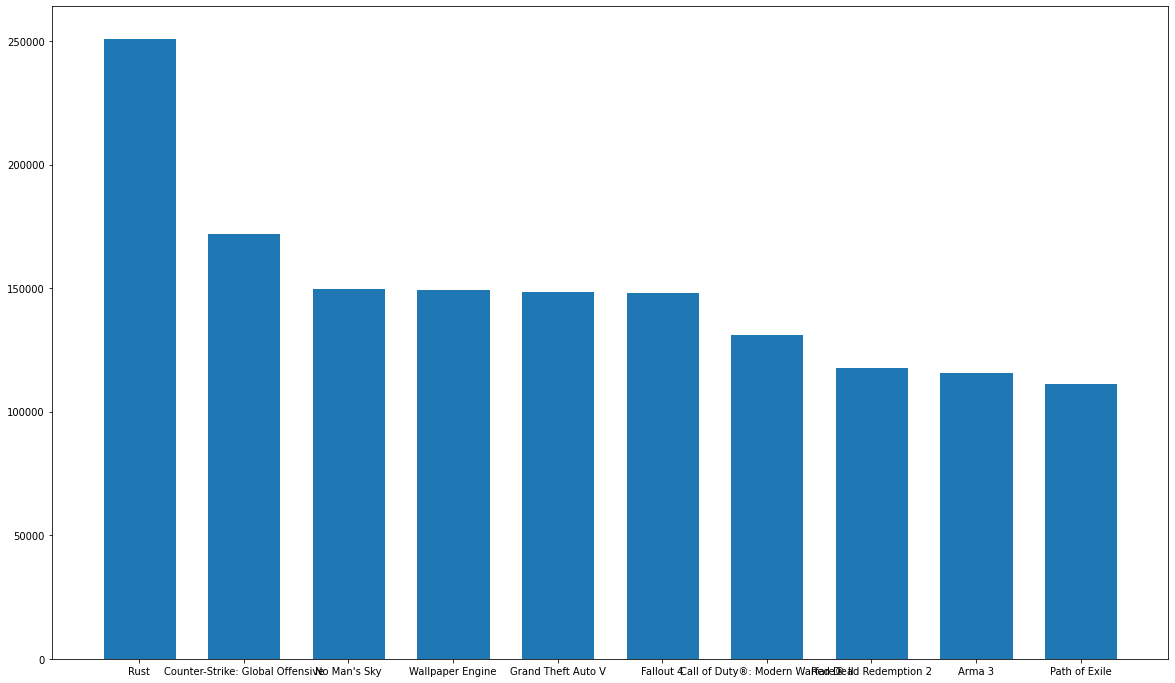

In [60]:
fig, ax = plt.subplots(figsize =(20,12))
ax.bar(count_data['title'][:10],count_data["count"][:10],width=0.7, edgecolor="white", linewidth=1)
# ax.set(xlim=(0, 8),ylim=(0, 8))

plt.show()

In [ ]:
# count_data.plt.plot.bar(x='count')  

In [ ]:
# count_datas = count_data.orderBy(f.col('count').desc())
# count_datas.show(20)

## ---- top buy games ----




In [ ]:
price = all_data.groupBy("app_id","title").sum()

In [ ]:
all_data.select(f.col("app_id"),f.col("title"),f.col("price_original")).filter("app_id == 252490").count()

251447

In [ ]:
all_data.select(f.col("app_id"),f.col("title"),f.col("price_original")).filter("app_id == 252490").show()

+------+-----+--------------+
|app_id|title|price_original|
+------+-----+--------------+
|252490| Rust|         39.99|
|252490| Rust|         39.99|
|252490| Rust|         39.99|
|252490| Rust|         39.99|
|252490| Rust|         39.99|
|252490| Rust|         39.99|
|252490| Rust|         39.99|
|252490| Rust|         39.99|
|252490| Rust|         39.99|
|252490| Rust|         39.99|
|252490| Rust|         39.99|
|252490| Rust|         39.99|
|252490| Rust|         39.99|
|252490| Rust|         39.99|
|252490| Rust|         39.99|
|252490| Rust|         39.99|
|252490| Rust|         39.99|
|252490| Rust|         39.99|
|252490| Rust|         39.99|
|252490| Rust|         39.99|
+------+-----+--------------+
only showing top 20 rows



In [ ]:
# from pyspark.sql.functions import *
price_ord = price.orderBy(f.col('sum(price_original)').desc())
price_ord.show(20)

+-------+--------------------+-----------------+-------------------+-------------------+-------------+--------------------+
| app_id|               title|sum(user_reviews)|   sum(price_final)|sum(price_original)|sum(discount)|          sum(hours)|
+-------+--------------------+-----------------+-------------------+-------------------+-------------+--------------------+
| 252490|                Rust| 1.81789391931E11|1.005536553004403E7|1.005536553004403E7|          0.0| 8.593886570000276E7|
|1938090|Call of Duty®: Mo...|  4.1615690244E10|  5975611.890018661|  9193956.390022406|    4597635.0|1.4871679199999869E7|
| 275850|        No Man's Sky|  2.9885551761E10|  9014517.330025472|  9014517.330025472|          0.0|1.9713485499999903E7|
|1174180|Red Dead Redempti...|  3.9877918581E10|  7076840.330018253|  7076840.330018253|          0.0|1.8209469800000146E7|
|1091500|      Cyberpunk 2077|  5.6995528928E10|  6558586.720016322|  6558586.720016322|          0.0|1.1497222400000196E7|
| 289070

## -----Top 10 popular games of 2022 with positive reviews-----

In [ ]:
game.show()

+------+--------------------+------------+----+-----+-----+---------------+--------------+------------+-----------+--------------+--------+----------+
|app_id|               title|date_release| win|  mac|linux|         rating|positive_ratio|user_reviews|price_final|price_original|discount|steam_deck|
+------+--------------------+------------+----+-----+-----+---------------+--------------+------------+-----------+--------------+--------+----------+
| 10090|Call of Duty: Wor...|  2008-11-18|true|false|false|  Very Positive|            92|     37039.0|      19.99|         19.99|     0.0|      true|
| 13500|Prince of Persia:...|  2008-11-21|true|false|false|  Very Positive|            84|      2199.0|       9.99|          9.99|     0.0|      true|
| 22364|BRINK: Agents of ...|  2011-08-03|true|false|false|       Positive|            85|        21.0|       2.99|          2.99|     0.0|      true|
|113020|Monaco: What's Yo...|  2013-04-24|true| true| true|  Very Positive|            92|    

In [ ]:
game_pos = game.select('app_id','title','date_release','user_reviews','positive_ratio').\
            filter((game["date_release"]>= lit('2022-01-01')) &(game["positive_ratio"]>=90))\
            .sort(f.col('user_reviews').desc(),f.col('positive_ratio').desc())

In [ ]:
game_pos.show(10)

+-------+--------------------+------------+------------+--------------+
| app_id|               title|date_release|user_reviews|positive_ratio|
+-------+--------------------+------------+------------+--------------+
|1245620|          ELDEN RING|  2022-02-24|    481754.0|            91|
| 648800|                Raft|  2022-06-20|    218598.0|            93|
|1794680|   Vampire Survivors|  2022-10-20|    175903.0|            98|
|1332010|               Stray|  2022-07-19|    101109.0|            97|
| 990080|     Hogwarts Legacy|  2023-02-10|     84327.0|            93|
|1593500|          God of War|  2022-01-14|     65968.0|            97|
|1167630|            Teardown|  2022-04-21|     60815.0|            96|
|1817070|Marvel’s Spider-M...|  2022-08-12|     41232.0|            96|
|1313140|    Cult of the Lamb|  2022-08-11|     40135.0|            93|
|1290000| PowerWash Simulator|  2022-07-14|     29465.0|            97|
+-------+--------------------+------------+------------+--------

## ----Top 10 popular games of 2022 with mixed or lower reviews----


In [ ]:
game_pos2 = game.select('app_id','title','date_release','user_reviews','positive_ratio').\
            filter((game["date_release"]>= lit('2022-01-01')) &(game["positive_ratio"] <= 70))\
            .sort(f.col('user_reviews').desc(),f.col('positive_ratio').desc())

In [ ]:
game_pos2.show(10)

+-------+--------------------+------------+------------+--------------+
| app_id|               title|date_release|user_reviews|positive_ratio|
+-------+--------------------+------------+------------+--------------+
|1938090|Call of Duty®: Mo...|  2022-10-27|    316804.0|            62|
|1811260|  EA SPORTS™ FIFA 23|  2022-09-29|     67263.0|            50|
|1361210|Warhammer 40000: ...|  2022-11-30|     54741.0|            54|
| 674020|         World War 3|  2022-12-10|     49594.0|            54|
| 868270| The Cycle: Frontier|  2022-06-08|     39025.0|            61|
|1418630|        Dread Hunger|  2022-01-26|     38500.0|            61|
|1544020|The Callisto Prot...|  2022-12-01|     21737.0|            62|
| 529340|          Victoria 3|  2022-10-25|     19223.0|            67|
|1816670|    GUNDAM EVOLUTION|  2022-09-19|     18407.0|            52|
|1969870|    生死狙击2 - 国服|  2022-07-20|     17380.0|            62|
+-------+--------------------+------------+------------+--------------

## ---- Top Genre popular ----

In [ ]:
game_tags.printSchema()
game_tags.show()

root
 |-- app_id: long (nullable = true)
 |-- description: string (nullable = true)
 |-- tags: array (nullable = true)
 |    |-- element: string (containsNull = true)

+------+--------------------+--------------------+
|app_id|         description|                tags|
+------+--------------------+--------------------+
| 10090|Call of Duty is b...|[Zombies, World W...|
| 13500|Enter the dark un...|[Action, Adventur...|
| 22364|                    |            [Action]|
|113020|Monaco: What's Yo...|[Co-op, Stealth, ...|
|226560|Escape Dead Islan...|[Zombies, Adventu...|
|249050|Dungeon of the En...|[Roguelike, Strat...|
|250180|“METAL SLUG 3”, t...|[Arcade, Classic,...|
|253980|Experience incred...|[RPG, Action, Fan...|
|261550|A strategy/action...|[Medieval, Strate...|
|271850|                    |[Strategy, Simula...|
|282900|Packed with fast-...|[Anime, JRPG, Fem...|
| 19810|Lead a team of do...|  [Action, Tactical]|
| 15270|In a ferocious Ar...|[Horror, Action, ...|
| 21130|Build th

In [ ]:
genre = all_data.select(f.col("app_id"),f.col("title"),f.col("price_final"),f.explode(f.col("tags")))

In [ ]:
ganre_2 = genre.orderBy(f.col('col').desc())
ganre_2.show(10)

+-------+--------------------+-----------+-------+
| app_id|               title|price_final|    col|
+-------+--------------------+-----------+-------+
|1058830|      Spin Rhythm XD|      19.99|eSports|
|1156120|         DOOMBRINGER|      14.99|eSports|
|1072190|   Crossfire: Legion|      29.99|eSports|
|1004750|WRC 8 FIA World R...|      29.99|eSports|
|1097130|  Circuit Superstars|      19.99|eSports|
|1021770|      Wanba Warriors|       4.99|eSports|
|1100990|            Aimbeast|       4.99|eSports|
|1114290|       Windjammers 2|      19.99|eSports|
|1126990|     PBA Pro Bowling|      14.99|eSports|
|1029550|        Torque Drift|        0.0|eSports|
+-------+--------------------+-----------+-------+
only showing top 10 rows



In [ ]:
# genre.show() all_data.groupBy("title").count().filter("count > 100")
ganre_3 = genre.select('title','col').groupBy("col").count().orderBy(f.col('count').desc())
# .filter(ganre_2["col"] != lit("eSports")).orderBy(f.col('col').desc())
ganre_3.show(10)

+------------+-------+
|         col|  count|
+------------+-------+
|      Action|5080011|
|Singleplayer|4755822|
| Multiplayer|4620768|
|       Co-op|3418037|
|   Adventure|3415202|
|First-Person|3312454|
|  Open World|3308630|
| Atmospheric|2800194|
|  Simulation|2519390|
|     Sandbox|2503436|
+------------+-------+
only showing top 10 rows



### Top Gerne Free game

In [ ]:
ganre_4 = ganre_2.select('title','col').filter("price_final == 0").groupBy("col").count().orderBy(f.col('count').desc())

In [ ]:
ganre_4.show(10)

+--------------------+------+
|                 col| count|
+--------------------+------+
|              Action|963121|
|         Multiplayer|956514|
|        Free to Play|852017|
|               Co-op|723990|
|           Adventure|631394|
|        Singleplayer|599761|
|                 PvP|573305|
|Massively Multipl...|536875|
|        Online Co-Op|509124|
|Character Customi...|454680|
+--------------------+------+
only showing top 10 rows



### Top Gerne Paid game

In [ ]:
ganre_5 = ganre_2.select('title','col').filter("price_final != 0").groupBy("col").count().orderBy(f.col('count').desc())

In [ ]:
ganre_5.show(10)

+------------+-------+
|         col|  count|
+------------+-------+
|Singleplayer|4156061|
|      Action|4116890|
| Multiplayer|3664254|
|  Open World|2931171|
|First-Person|2906236|
|   Adventure|2783808|
|       Co-op|2694047|
| Atmospheric|2558543|
|     Sandbox|2226187|
|  Simulation|2184336|
+------------+-------+
only showing top 10 rows



### Top Gerne eSpots game

In [ ]:
ganre_6 =  ganre_2.select('title').filter("col == 'eSports'").groupBy("title").count().orderBy(f.col('count').desc())

In [ ]:
ganre_6.show(10)

+--------------------+------+
|               title| count|
+--------------------+------+
|Counter-Strike: G...|172422|
|          Brawlhalla| 99033|
|              Dota 2| 61361|
|              SMITE®| 50588|
|Yu-Gi-Oh! Master ...| 18817|
|  EA SPORTS™ FIFA 23| 16772|
|            NBA 2K23|  5685|
|DRAGON BALL FighterZ|  4885|
|Football Manager ...|  3005|
|       Madden NFL 23|  2508|
+--------------------+------+
only showing top 10 rows



## ----Top Gerane Games ----

In [ ]:
ganre_3.show(10)

+------------+-------+
|         col|  count|
+------------+-------+
|      Action|5080011|
|Singleplayer|4755822|
| Multiplayer|4620768|
|       Co-op|3418037|
|   Adventure|3415202|
|First-Person|3312454|
|  Open World|3308630|
| Atmospheric|2800194|
|  Simulation|2519390|
|     Sandbox|2503436|
+------------+-------+
only showing top 10 rows



### By Action

In [ ]:
top_game1 = ganre_2.select('title').filter("col == 'Action'").groupBy("title").count().orderBy(f.col('count').desc())

In [ ]:
top_game1.show(10)

+--------------------+------+
|               title| count|
+--------------------+------+
|                Rust|251447|
|Counter-Strike: G...|172422|
|        No Man's Sky|150267|
|    Wallpaper Engine|149644|
|  Grand Theft Auto V|148839|
|           Fallout 4|148538|
|Call of Duty®: Mo...|131361|
|Red Dead Redempti...|117967|
|              Arma 3|115929|
|       Path of Exile|111579|
+--------------------+------+
only showing top 10 rows



### By Singleplayer

In [ ]:
top_game2 = ganre_2.select('title').filter("col == 'Singleplayer'").groupBy("title").count().orderBy(f.col('count').desc())

In [ ]:
top_game2.show(10)

+--------------------+------+
|               title| count|
+--------------------+------+
|        No Man's Sky|150267|
|    Wallpaper Engine|149644|
|  Grand Theft Auto V|148839|
|           Fallout 4|148538|
|Call of Duty®: Mo...|131361|
|Red Dead Redempti...|117967|
|              Arma 3|115929|
|       Path of Exile|111579|
|      Cyberpunk 2077|109328|
|      Sea of Thieves|108191|
+--------------------+------+
only showing top 10 rows



### By Multiplayer

In [ ]:
top_game3 = ganre_2.select('title').filter("col == 'Multiplayer'").groupBy("title").count().orderBy(f.col('count').desc())

In [ ]:
top_game3.show(10)

+--------------------+------+
|               title| count|
+--------------------+------+
|                Rust|251447|
|Counter-Strike: G...|172422|
|        No Man's Sky|150267|
|  Grand Theft Auto V|148839|
|Call of Duty®: Mo...|131361|
|Red Dead Redempti...|117967|
|              Arma 3|115929|
|       Path of Exile|111579|
|      Sea of Thieves|108191|
|   Hearts of Iron IV|104752|
+--------------------+------+
only showing top 10 rows



### By Co-op

In [ ]:
top_game4 = ganre_2.select('title').filter("col == 'Co-op'").groupBy("title").count().orderBy(f.col('count').desc())

In [ ]:
top_game4.show(10)

+--------------------+------+
|               title| count|
+--------------------+------+
|                Rust|251447|
|Counter-Strike: G...|172422|
|  Grand Theft Auto V|148839|
|Call of Duty®: Mo...|131361|
|              Arma 3|115929|
|       Path of Exile|111579|
|      Sea of Thieves|108191|
|   Hearts of Iron IV|104752|
|          Brawlhalla| 99033|
|The Binding of Is...| 98643|
+--------------------+------+
only showing top 10 rows



### By Adventure

In [ ]:
top_game5 = ganre_2.select('title').filter("col == 'Adventure'").groupBy("title").count().orderBy(f.col('count').desc())

In [ ]:
top_game5.show(10)

+--------------------+------+
|               title| count|
+--------------------+------+
|                Rust|251447|
|        No Man's Sky|150267|
|  Grand Theft Auto V|148839|
|           Fallout 4|148538|
|Red Dead Redempti...|117967|
|       Path of Exile|111579|
|      Cyberpunk 2077|109328|
|      Sea of Thieves|108191|
|            Lost Ark| 94162|
|        BeamNG.drive| 90970|
+--------------------+------+
only showing top 10 rows



### By First-Person

In [ ]:
top_game6 = ganre_2.select('title').filter("col == 'First-Person'").groupBy("title").count().orderBy(f.col('count').desc())

In [ ]:
top_game6.show(10)

+--------------------+------+
|               title| count|
+--------------------+------+
|                Rust|251447|
|Counter-Strike: G...|172422|
|        No Man's Sky|150267|
|    Wallpaper Engine|149644|
|  Grand Theft Auto V|148839|
|           Fallout 4|148538|
|Call of Duty®: Mo...|131361|
|Red Dead Redempti...|117967|
|              Arma 3|115929|
|      Cyberpunk 2077|109328|
+--------------------+------+
only showing top 10 rows



### By Open World

In [ ]:
top_game7 = ganre_2.select('title').filter("col == 'Open World'").groupBy("title").count().orderBy(f.col('count').desc())

In [ ]:
top_game7.show(10)

+--------------------+------+
|               title| count|
+--------------------+------+
|                Rust|251447|
|        No Man's Sky|150267|
|  Grand Theft Auto V|148839|
|           Fallout 4|148538|
|Red Dead Redempti...|117967|
|              Arma 3|115929|
|      Cyberpunk 2077|109328|
|      Sea of Thieves|108191|
|   Hearts of Iron IV|104752|
|        BeamNG.drive| 90970|
+--------------------+------+
only showing top 10 rows



### By Atmospheric

In [ ]:
top_game8 = ganre_2.select('title').filter("col == 'Atmospheric'").groupBy("title").count().orderBy(f.col('count').desc())

In [ ]:
top_game8.show(10)

+--------------------+------+
|               title| count|
+--------------------+------+
|        No Man's Sky|150267|
|  Grand Theft Auto V|148839|
|           Fallout 4|148538|
|Call of Duty®: Mo...|131361|
|Red Dead Redempti...|117967|
|      Cyberpunk 2077|109328|
|      Sea of Thieves|108191|
|The Binding of Is...| 98643|
|Sid Meier’s Civil...| 83191|
|The Elder Scrolls...| 68834|
+--------------------+------+
only showing top 10 rows



### By Simulation

In [ ]:
top_game9 = ganre_2.select('title').filter("col == 'Simulation'").groupBy("title").count().orderBy(f.col('count').desc())

In [ ]:
top_game9.show(10)

+--------------------+------+
|               title| count|
+--------------------+------+
|                Rust|251447|
|        No Man's Sky|150267|
|              Arma 3|115929|
|   Hearts of Iron IV|104752|
|        BeamNG.drive| 90970|
|              VRChat| 87365|
|Sid Meier’s Civil...| 83191|
|     Space Engineers| 76198|
|        Satisfactory| 68495|
|Tom Clancy's Rain...| 67570|
+--------------------+------+
only showing top 10 rows



### By Sandbox

In [ ]:
top_game10 = ganre_2.select('title').filter("col == 'Sandbox'").groupBy("title").count().orderBy(f.col('count').desc())

In [ ]:
top_game10.show(10)

+--------------------+------+
|               title| count|
+--------------------+------+
|                Rust|251447|
|        No Man's Sky|150267|
|    Wallpaper Engine|149644|
|  Grand Theft Auto V|148839|
|           Fallout 4|148538|
|Red Dead Redempti...|117967|
|              Arma 3|115929|
|   Hearts of Iron IV|104752|
|        BeamNG.drive| 90970|
|              VRChat| 87365|
+--------------------+------+
only showing top 10 rows



## ----Trend by time----

In [ ]:
trend = all_data.groupBy("title",'date_release').count().orderBy(f.col('count').desc())

In [ ]:
trend.show(10)

+--------------------+------------+------+
|               title|date_release| count|
+--------------------+------------+------+
|                Rust|  2018-02-08|251447|
|Counter-Strike: G...|  2012-08-21|172422|
|        No Man's Sky|  2016-08-12|150267|
|    Wallpaper Engine|  2018-11-01|149644|
|  Grand Theft Auto V|  2015-04-13|148839|
|           Fallout 4|  2015-11-09|148538|
|Call of Duty®: Mo...|  2022-10-27|131361|
|Red Dead Redempti...|  2019-12-05|117967|
|              Arma 3|  2013-09-12|115929|
|       Path of Exile|  2013-10-23|111579|
+--------------------+------------+------+
only showing top 10 rows



### By < 2000


In [ ]:
trend1 = all_data.filter((f.year('date_release') < lit('2000'))).groupBy("title",'date_release').count().orderBy(f.col('count').desc())

In [ ]:
trend1.show()

+--------------------+------------+-----+
|               title|date_release|count|
+--------------------+------------+-----+
|Carmageddon Max Pack|  1997-06-30|    1|
|           Half-Life|  1998-11-08|    1|
|Team Fortress Cla...|  1999-04-01|    1|
|Half-Life: Opposi...|  1999-11-01|    1|
+--------------------+------------+-----+



### By 2000-2005

In [ ]:
trend2 = all_data.filter((f.year('date_release') > lit('2000')) &(f.year('date_release') <= lit('2005'))).groupBy("title",'date_release').count().orderBy(f.col('count').desc())

In [ ]:
trend2.show(10)

+--------------------+------------+-----+
|               title|date_release|count|
+--------------------+------------+-----+
|Half-Life: Blue S...|  2001-06-01|    1|
|   Half-Life: Source|  2004-06-01|    1|
|  Deathmatch Classic|  2001-06-01|    1|
|       Day of Defeat|  2003-05-01|    1|
|Half-Life 2: Deat...|  2004-11-01|    1|
|               Mafia|  2002-08-28|    1|
|Counter-Strike: S...|  2004-11-01|    1|
|Sid Meier's Pirates!|  2005-07-11|    1|
|    Rag Doll Kung Fu|  2005-10-12|    1|
+--------------------+------------+-----+



### By 2005- 2010 

In [ ]:
trend3 = all_data.filter((f.year('date_release') > lit('2005')) &(f.year('date_release') <= lit('2010'))).groupBy("title",'date_release').count().orderBy(f.col('count').desc())

In [ ]:
trend3.show(10)

+--------------------+------------+-----+
|               title|date_release|count|
+--------------------+------------+-----+
|         Garry's Mod|  2006-11-29|35199|
|  Fallout: New Vegas|  2010-10-19|18488|
|Call of Duty®: Bl...|  2010-11-09|18359|
|       Left 4 Dead 2|  2009-11-16|11522|
|     Team Fortress 2|  2007-10-10| 3787|
|Space Quest™ Coll...|  2009-07-23|    1|
|         X3: Reunion|  2006-07-21|    1|
|  Bejeweled 2 Deluxe|  2006-08-30|    1|
|             ArcaniA|  2010-10-15|    1|
|        Patrician IV|  2010-09-17|    1|
+--------------------+------------+-----+
only showing top 10 rows



### By 2010 - 2015 

In [ ]:
trend4 = all_data.filter((f.year('date_release') > lit('2010')) &(f.year('date_release') <= lit('2015'))).groupBy("title",'date_release').count().orderBy(f.col('count').desc())

In [ ]:
trend4.show(10)

+--------------------+------------+------+
|               title|date_release| count|
+--------------------+------------+------+
|Counter-Strike: G...|  2012-08-21|172422|
|  Grand Theft Auto V|  2015-04-13|148839|
|           Fallout 4|  2015-11-09|148538|
|              Arma 3|  2013-09-12|115929|
|       Path of Exile|  2013-10-23|111579|
|The Binding of Is...|  2014-11-04| 98643|
|        BeamNG.drive|  2015-05-29| 90970|
|Tom Clancy's Rain...|  2015-12-01| 67570|
|            PAYDAY 2|  2013-08-13| 63813|
|              Dota 2|  2013-07-09| 61361|
+--------------------+------------+------+
only showing top 10 rows



### By 2015 - 2020

In [ ]:
trend5 = all_data.filter((f.year('date_release') > lit('2015')) &(f.year('date_release') <= lit('2020'))).groupBy("title",'date_release').count().orderBy(f.col('count').desc())

In [ ]:
trend5.show(10)

+--------------------+------------+------+
|               title|date_release| count|
+--------------------+------------+------+
|                Rust|  2018-02-08|251447|
|        No Man's Sky|  2016-08-12|150267|
|    Wallpaper Engine|  2018-11-01|149644|
|Red Dead Redempti...|  2019-12-05|117967|
|      Cyberpunk 2077|  2020-12-09|109328|
|      Sea of Thieves|  2020-06-03|108191|
|   Hearts of Iron IV|  2016-06-06|104752|
|          Brawlhalla|  2017-10-17| 99033|
|              VRChat|  2017-02-01| 87365|
|Sid Meier’s Civil...|  2016-10-20| 83191|
+--------------------+------------+------+
only showing top 10 rows



### By >= 2020

In [ ]:
trend6 = all_data.filter((f.year('date_release') >= lit('2020'))).groupBy("title",'date_release').count().orderBy(f.col('count').desc())

In [ ]:
trend6.show(10)

+--------------------+------------+------+
|               title|date_release| count|
+--------------------+------------+------+
|Call of Duty®: Mo...|  2022-10-27|131361|
|      Cyberpunk 2077|  2020-12-09|109328|
|      Sea of Thieves|  2020-06-03|108191|
|            Lost Ark|  2022-02-11| 94162|
|        Satisfactory|  2020-06-08| 68495|
|               Stray|  2022-07-19| 56284|
|Dying Light 2 Sta...|  2022-02-03| 55244|
|          ELDEN RING|  2022-02-24| 55120|
|Mount & Blade II:...|  2022-10-25| 54219|
|       Borderlands 3|  2020-03-13| 50566|
+--------------------+------------+------+
only showing top 10 rows

